# Lista 3 - MULTIPLE SEQUENCE ALIGNMENT - MSA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import uniprot
import pprint
import requests
import re
import seaborn as sns 
import os
import plotly.graph_objects as go
import pandas as pd

In [2]:
def open_seq(path_or_id):

    """
    Opening a file based on the provided path or fetching data from the Uniprot website based on the given ID and extracting the sequence.

    Args:
    path_or_id (str): Path to the file or protein ID

    Returns:
    str: Extracted sequence

    Raises:
    FileNotFoundError: If the file is not found
    ValueError: If the extracted sequence does not have a valid format
    """

    url="http://www.uniprot.org/uniprot/"
        # url = f"https://www.uniprot.org/uniprot/{path_or_id}.fasta"
    seq = " "
    read = ''

    if ".fasta" in path_or_id:
        try:
            with open(path_or_id, "r") as f:
                read = f.read()

        except FileNotFoundError:
                print("Not found your file")
    else:
            currentUrl = url + path_or_id + ".fasta"
            response = r.post(currentUrl)
            read= response.text

    seq_alf = r'[ACDEFGHIKLMNPQRSTUVWY]+' 


    if ">" in read:
        sequence = ''.join(read.split('\n')[1:])
        sequence.upper()

        if bool(re.fullmatch( seq_alf , sequence)) == False:
            raise ValueError("Sequence contains unacceptable characters")
        else:  
            return sequence
    else:
        raise ValueError("Header do not start with >")


# Algorytm Needelmana Wuncha

In [3]:

def generate_matrix(seq1, seq2, gap):
    """
    Generates two matrices for global sequence alignment.

    Parameters:
    seq1 (str): The first sequence.
    seq2 (str): The second sequence.
    gap (int): Gap penalty value.

    Returns:
    tuple: A tuple containing two matrices: scoring matrix and traceback matrix.
    """

    n = len(seq1)
    m = len(seq2)
    matrix = np.zeros((n + 1, m + 1))
    matrix_str = np.zeros((n + 1, m + 1))

    # Initialize the first row and column with gap penalties and direction indicators
    for i in range(1, n + 1):
        matrix[i, 0] = matrix[i - 1, 0] + gap
        matrix_str[i, 0] = 1  # 'U' indicates upward direction

    for j in range(1, m + 1):
        matrix[0, j] = matrix[0, j - 1] + gap
        matrix_str[0, j] = 2  # 'L' indicates leftward direction

    return matrix, matrix_str

def global_alignment(seq1, seq2, gap, match, mismatch):
    """
    Performs global sequence alignment using dynamic programming.

    Parameters:
    seq1 (str): The first sequence.
    seq2 (str): The second sequence.
    gap (int): Gap penalty value.
    match (int): Score for a match.
    mismatch (int): Penalty for a mismatch.

    Returns:
    tuple: A tuple containing two matrices: scoring matrix and traceback matrix.
    """

    matrix, matrix_str = generate_matrix(seq1, seq2, gap)
    str_track = {"U": 1, "L": 2, "D": 3}  # Direction indicators

    for i in range(1, len(seq1) + 1):
        for j in range(1, len(seq2) + 1):
            # Calculate the scores for three possible moves
            match1 = matrix[i - 1, j - 1] + (match if seq1[i - 1] == seq2[j - 1] else mismatch)
            matrix[i, j] = max(matrix[i - 1, j] + gap, matrix[i, j - 1] + gap, match1)

            # Determine the direction for traceback based on the maximum score
            if matrix[i, j] == matrix[i - 1, j] + gap:
                matrix_str[i, j] = str_track["U"]
            elif matrix[i, j] == matrix[i, j - 1] + gap:
                matrix_str[i, j] = str_track["L"]
            else:
                matrix_str[i, j] = str_track["D"]

    return matrix, matrix_str

def traceback_global(seq1, seq2, matrix_str, gap):
    """
    Performs traceback to retrieve the aligned sequences from the traceback matrix.

    Parameters:
    seq1 (str): The first sequence.
    seq2 (str): The second sequence.
    matrix_str (numpy.ndarray): The traceback matrix obtained from global alignment.
    gap (int): Gap penalty value.

    Returns:
    tuple: A tuple containing the aligned sequences.
    """

    str_track = {"U": 1, "L": 2, "D": 3}  # Direction indicators
    new_seq1 = []
    new_seq2 = []
    i, j = len(seq1), len(seq2)

    # Traceback from the bottom-right cell to reconstruct aligned sequences
    while i > 0 or j > 0:
        if matrix_str[i, j] == str_track["D"]:
            new_seq1.append(seq1[i - 1])
            new_seq2.append(seq2[j - 1])
            i -= 1
            j -= 1
        elif matrix_str[i, j] == str_track["U"]:
            new_seq1.append(seq1[i - 1])
            new_seq2.append('-')  # Gap in seq2
            i -= 1
        elif matrix_str[i, j] == str_track["L"]:
            new_seq1.append('-')  # Gap in seq1
            new_seq2.append(seq2[j - 1])
            j -= 1

    return ''.join(new_seq1[::-1]), ''.join(new_seq2[::-1])


## Generowanie macierzy z scorem z wszystkich dopasowań, oraz znalezienie sekwencji centralnej

In [4]:
def central_aligment(seqs, gap, match, mismatch):
    """
    Performs central sequence alignment for a list of sequences.

    This function aligns a list of sequences against each other to find a central alignment,
    maximizing the overall alignment score.

    Parameters:
    seqs (list of str): List of sequences to be aligned.
    gap (int): Gap penalty value.
    match (int): Score for a match.
    mismatch (int): Penalty for a mismatch.

    Returns:
    tuple: A tuple containing:
        - numpy.ndarray: Matrix of alignment scores between sequences.
        - int: Score of the central alignment.
        - int: Index of the sequence chosen as the central alignment.
    """

    number_of_seqs = len(seqs)   # liczba seq
    matrix_of_score = np.zeros((number_of_seqs, number_of_seqs+1))  #wyniki dopasowania

    for i in range(number_of_seqs):   # dopasowania kazda z kazda
        for j in range(number_of_seqs):
            mat, mat_track = global_alignment(seqs[i], seqs[j], gap, match, mismatch)
            score = mat[len(seqs[i]), len(seqs[j])]

            if i==j:
                matrix_of_score[i,j] = 0
            else:
                matrix_of_score[i,j] = score
                matrix_of_score[i, number_of_seqs] += score  
            
    msa_score = 0
    index_of_aligment = 0
    for i in range(number_of_seqs):
        msa_sc = matrix_of_score[i, number_of_seqs]  # sumowanie dla danej seq dopsaowania

        if (msa_sc > msa_score):
            msa_score = msa_sc
            index_of_aligment = i

    return matrix_of_score, msa_score, index_of_aligment




In [5]:
def get_MSA(seqs, index_of_aligment):
    """
    Retrieves the central sequence from a list of sequences based on the index of alignment.

    This function retrieves the central sequence from a list of sequences based on the index
    of the alignment chosen as the central alignment.

    Parameters:
    seqs (list of str): List of sequences.
    index_of_alignment (int): Index of the sequence chosen as the central alignment.

    Returns:
    str: The central sequence.
    """
    # Pobranie centralnej sekwencji na podstawie indeksu wybranej sekwencji
    number_of_seqs = len(seqs)
    
    return seqs[index_of_aligment]



## Ponowne porównanie sekwencji w prach z sekwnecją centralną

In [6]:
def final_MSA(seqs, MSA,  gap, match, mismatch):
    """
    Performs final multiple sequence alignment (MSA) against a central alignment.

    This function performs the final multiple sequence alignment (MSA) against a central alignment
    for a list of sequences. It aligns each sequence with the central alignment sequence (MSA)
    using global alignment and retrieves the aligned sequences.

    Parameters:
    seqs (list of str): List of sequences to be aligned.
    MSA (str): Central alignment sequence.
    gap (int): Gap penalty value.
    match (int): Score for a match.
    mismatch (int): Penalty for a mismatch.

    Returns:
    dict: A dictionary containing aligned sequences for each input sequence index.
          Each key corresponds to the index of the input sequence, and the value is a tuple
          containing the aligned sequences with the central alignment sequence.
    """
    number_of_seqs = len(seqs)
    final_MSA = {}  # Inicjalizacja słownika do przechowywania dopasowanych sekwencji
    i = 0
    while i < number_of_seqs:
        if (MSA == seqs[i]):
            i += 1
        else:
            # Wykonanie globalnego dopasowania między MSA a bieżącą sekwencją
            matrix, matrix_str = global_alignment(MSA, seqs[i], gap, match, mismatch)
             # Pobranie dopasowanych sekwencji
            seq1, seq2 = traceback_global(MSA, seqs[i], matrix_str, gap)
            # Zapisanie dopasowanych sekwencji w słowniku final_MSA
            final_MSA[i] = seq1,seq2

            i += 1
    return final_MSA

        


# Dopasowanie końcowe

In [7]:
def final_final_version(MSA, seqs):
    """
    Performs final adjustments to multiple sequence alignment (MSA) relative to the central alignment.

    This function performs final adjustments to multiple sequence alignment (MSA) relative to the central alignment.
    The adjustments involve inserting "-" characters in sequences that contain gaps relative to the central sequence.

    Parameters:
    MSA (str): The central alignment sequence.
    seqs (dict): A dictionary containing aligned sequences for each input sequence index.
                 Each key corresponds to the index of the input sequence, and the value is a tuple
                 containing aligned sequences with respect to the central alignment sequence.

    Returns:
    list: List of sequences after final adjustment of alignment.
    """
    MSA_new = MSA
    seq_msa =[]
    seq_another = []

    # Przypisanie sekwencji MSA do nowej zmiennej MSA_new
    # oraz zapisanie sekwencji z sekwencji MSA i innych sekwencji do osobnych list
    for k11, v11 in seqs.items():
        seq_msa.append(v11[0])  
        seq_another.append(v11[1])

    for i in seq_msa:    # Iteracja po sekwencjach w seq_msa (sekwencjach pochodzących z MSA)

        indexi = seq_msa.index(i)
        if i !=MSA_new:   # Sprawdzenie, czy sekwencja jest różna od sekwencji MSA_new
            temp_msa = i
            temp_seq = 'proba'

            for j in range(len(temp_msa)):    # Iteracja po indeksach w sekwencji temp_msa
                
                # Jeśli w temp_msa jest znak "-", to zostanie wstawiony w MSA_new i odpowiednich sekwencjach
                if temp_msa[j] == '-' and j < len(MSA_new) and MSA_new[j] != '-':

                    MSA_new = MSA_new[:j] + '-' + MSA_new[j:] # jak w temp_msa jest - to wsadzamy go do MSA_new j to index
                    
                    for k, string in enumerate(seq_another):
     

                        if k != indexi:
                            seq_another[k] = seq_another[k][:j] + '-' + seq_another[k][j:]
                # Jeśli temp_msa ma dłuższy indeks niż MSA_new, to znak "-" zostanie dołączony na końcu MSA_new
                elif  temp_msa[j] == '-' and j >= len(MSA_new) :
                    MSA_new = MSA_new + '-'

                    for k, string in enumerate(seq_another):

                        if k != indexi:
                            seq_another[k] = seq_another[k][:j] + '-' + seq_another[k][j:]
     # Dodanie MSA_new na początku listy seq_another
    seq_another = [MSA_new]+ seq_another

    return seq_another

# Wyświetlenie graficzne

In [8]:
# def grafic_show(seq_another, gap, match, mismatch):
#     """
#     Visualizes the multiple sequence alignment (MSA) using a heatmap.

#     This function visualizes the multiple sequence alignment (MSA) using a heatmap,
#     where each amino acid or gap symbol is represented by a unique color.

#     Parameters:
#     seq_another (list): List of sequences after final adjustment of alignment.

#     Returns:
#     None
#     """
#     aminoacids = {  # Słownik mapujący aminokwasy i symbol luki na wartości numeryczne
#         "A": 1,
#         "C": 2,
#         "D": 3,
#         "E": 4,
#         "F": 5,
#         "G": 6,
#         "H": 7,
#         "I": 8,
#         "K": 9,
#         "L": 10,
#         "M": 11,
#         "N": 12,
#         "P": 13,
#         "Q": 14,
#         "R": 15,
#         "S": 16,
#         "T": 17,
#         "V": 18,
#         "W": 19,
#         "Y": 20,
#         "-":50      
#     }
#     converted_sequences = []
#     # Konwersja sekwencji na reprezentacje numeryczne za pomocą słownika aminoacids
#     for sequence in seq_another:
#         converted_sequence = [aminoacids[letter] for letter in sequence]
#         converted_sequences.append(converted_sequence)   # cyferki

#     split_sequences = [list(sequence) for sequence in seq_another]   # Podział sekwencji na listy pojedynczych znaków


#     fig, ax = plt.subplots() 
#     ax.xaxis.set_ticks_position('none') 
#     ax.yaxis.set_ticks_position('none') 
#     ax.tick_params(length=0) 
    

#     sns.heatmap(converted_sequences, annot=split_sequences, fmt="", cbar=False, ax=ax)

#     # ax.set_xticklabels(list(range(1, len(seq_another[0]) + 1)))
#     ax.set_xticks(range(len(seq_another[0])))
#     ax.set_xticklabels(list(range(1, len(seq_another[0]) + 1)), rotation=90) 
#     ax.set_yticklabels(['MSA'] + [f"seq{i+1}" for i in range(1, len(seq_another))])
#     ax.set_xlabel('Position')
#     ax.set_title(f'Multiple Sequence Alignment (MSA) \n gap: {gap}, match: {match}, mismatch: {mismatch} ')
#     mplcursors.cursor(hover=True)

#     plt.show()

# import plotly.graph_objects as go
# def grafic_show(seq_another, gap, match, mismatch):
#     aminoacids = {
#         "A": 1, "C": 2, "D": 3, "E": 4, "F": 5, "G": 6, "H": 7, "I": 8, "K": 9, "L": 10,
#         "M": 11, "N": 12, "P": 13, "Q": 14, "R": 15, "S": 16, "T": 17, "V": 18, "W": 19,
#         "Y": 20, "-": 50
#     }

#     converted_sequences = np.zeros((len(seq_another), len(seq_another[0])))
#     for i, sequence in enumerate(seq_another):
#         for j, letter in enumerate(sequence):
#             converted_sequences[i, j] = aminoacids[letter]

#     fig = go.Figure()

#     fig.add_trace(go.Heatmap(z=converted_sequences,
#                              colorscale='Magma',  # Zmiana na przyjemniejszy zestaw kolorów
#                              showscale=False,
#                              x0=0,
#                              dx=1,
#                              y0=0,
#                              dy=1,
#                              hoverinfo='text',
#                              text=seq_another))  # Użyj oryginalnych sekwencji jako tekstu

#     fig.update_layout(title=f'Multiple Sequence Alignment (MSA)\ngap: {gap}, match: {match}, mismatch: {mismatch}',
#                       xaxis_title='Position',
#                       yaxis_title='Sequence',
#                       xaxis=dict(ticks='outside', tickangle=90),
#                       yaxis=dict(ticks='outside', tickmode='array', tickvals=list(range(len(seq_another))), ticktext=["MSA"] + [f'seq{i+2}' for i in range(len(seq_another) - 1)]))

#     fig.show()
# import plotly.graph_objects as go
# import pandas as pd

# def grafic_show(seq_another, gap, match, mismatch):
#     """
#     Visualizes the multiple sequence alignment (MSA) using an interactive heatmap with Plotly,
#     with annotations for each amino acid.

#     Parameters:
#     seq_another (list of str): List of sequences after final adjustment of alignment.
#     gap (int): Numeric value representing a gap in the alignment.
#     match (int): Numeric value representing a match in the alignment.
#     mismatch (int): Numeric value representing a mismatch in the alignment.

#     Returns:
#     None
#     """
#     aminoacids = {
#         "A": 1, "C": 2, "D": 3, "E": 4, "F": 5, "G": 6, "H": 7, "I": 8, 
#         "K": 9, "L": 10, "M": 11, "N": 12, "P": 13, "Q": 14, "R": 15, 
#         "S": 16, "T": 17, "V": 18, "W": 19, "Y": 20, "-": 50      
#     }
#     # Convert sequences to numeric representation using the aminoacids dictionary
#     numeric_sequences = [[aminoacids[aa] for aa in seq] for seq in seq_another]
#     # Prepare DataFrame for easier annotation handling
#     df = pd.DataFrame(numeric_sequences, columns=[f"Pos {i+1}" for i in range(len(seq_another[0]))], index=[f"Seq {i+1}" for i in range(len(seq_another))])

#     # Prepare annotations
#     annotations = []
#     for y, sequence in enumerate(seq_another):
#         for x, char in enumerate(sequence):
#             annotations.append(
#                 dict(
#                     showarrow=False,
#                     x=x,
#                     y=y,
#                     text=char,
#                     xref="x",
#                     yref="y"
#                 )
#             )

#     # Create the heatmap with annotations
#     fig = go.Figure(data=go.Heatmap(
#         z=df.values,
#         x=df.columns,
#         y=df.index,
#         showscale=True,
#         colorscale="Viridis"
#     ))
#     fig.update_layout(
#         title=f"Multiple Sequence Alignment (MSA) Visualization<br>Gap: {gap}, Match: {match}, Mismatch: {mismatch}",
#         annotations=annotations,
#         xaxis=dict(ticks="", side="top"),
#         yaxis=dict(ticks="")
#     )

#     fig.show()





def grafic_show(seq_another, gap, match, mismatch):
    """
    Visualizes the multiple sequence alignment (MSA) using an interactive heatmap with Plotly,
    with annotations for each amino acid, customized labels, and without a color scale.

    Parameters:
    seq_another (list of str): List of sequences after final adjustment of alignment.
    gap (int): Numeric value representing a gap in the alignment.
    match (int): Numeric value representing a match in the alignment.
    mismatch (int): Numeric value representing a mismatch in the alignment.

    Returns:
    None
    """
    aminoacids = {
        "A": 1, "C": 2, "D": 3, "E": 4, "F": 5, "G": 6, "H": 7, "I": 8, 
        "K": 9, "L": 10, "M": 11, "N": 12, "P": 13, "Q": 14, "R": 15, 
        "S": 16, "T": 17, "V": 18, "W": 19, "Y": 20, "-": 50      
    }

    numeric_sequences = [[aminoacids[aa] for aa in seq] for seq in seq_another]

    df = pd.DataFrame(numeric_sequences, columns=[f"{i+1}" for i in range(len(seq_another[0]))])
    df.index = ["MSA"] + [f"Seq {i+1}" for i in range(1, len(seq_another))]


    annotations = []
    for y, sequence in enumerate(seq_another):
        for x, char in enumerate(sequence):
            annotations.append(
                dict(
                    showarrow=False,
                    x=x,
                    y=y,
                    text=char,
                    xref="x",
                    yref="y"
                )
            )

    fig = go.Figure(data=go.Heatmap(
        z=df.values,
        x=df.columns,
        y=df.index,
        showscale=False,  # Remove the color scale
        colorscale="RdBu"

    ))
    fig.update_layout(
        title=f"Multiple Sequence Alignment (MSA) Visualization<br>Gap: {gap}, Match: {match}, Mismatch: {mismatch}",
        annotations=annotations,
        xaxis=dict(ticks="", side="bottom"),  # Position x-axis ticks at the bottom
        yaxis=dict(ticks="")
    )

    fig.show()




# Zapis do pliku

In [9]:


def save_results_global(seqs, aligned_seqs_dict, gap_count, mismatch_count, matching_positions, matrix, MSA, globalAligment, final, file_name="results.txt"):

    results = [
        f"Sequences before alignment: {seqs}\n",
        f"Gap: {gap_count}\n",
        f"Mismatch: {mismatch_count}\n",
        f"Match: {matching_positions}\n",
        f"Sequence aligment results:\n {matrix}\n",
        f"MSA sequence: {MSA}\n",
        f"Sequences after needleman wunsch matching: {globalAligment}\n",
        f"Final version: {final}\n",
    ]

    # Zmiana nazwy pliku, jeśli już istnieje
    if os.path.exists(file_name):
        file_name, file_extension = os.path.splitext(file_name)
        i = 1
        while os.path.exists(f"{file_name}_{i}{file_extension}"):
            i += 1
        file_name = f"{file_name}_{i}{file_extension}"
    
    # Zapis danych do pliku
    with open(file_name, "w") as file:
        for line in results:
            file.write(line + "\n")


# Wywołanie - zwykle

In [10]:

seq1 = "ATTGCCATT"
seq2 = "ATGGCCATT"
seq3 = "ATCCAATTTT"
seq4 = "ATCTTCTT"
seq5 = "ACTGACC"

seqs = [seq1, seq2, seq3, seq4, seq5]

gap = -2
match = 1
mismatch = -1


matrix_of_score, msa_score, index_of_aligment= central_aligment(seqs, gap, match, mismatch)

MSA = get_MSA(seqs, index_of_aligment)
print("MSA: " + MSA)

globalAlignment = final_MSA(seqs, MSA,  gap, match, mismatch)
print("Matching sequences each with each" + str(globalAlignment))

final = final_final_version(MSA, globalAlignment)
# print("Final version, first sequence is MSA" + str(final))
grafic_show(final, gap, match, mismatch)

save_results_global(seqs, seqs, gap, mismatch, match, matrix_of_score, MSA, globalAlignment, final, file_name="wyniki.txt")



MSA: ATTGCCATT
Matching sequences each with each{1: ('ATTGCCATT', 'ATGGCCATT'), 2: ('ATTGCCATT--', 'ATC-CAATTTT'), 3: ('ATTGCCATT', 'ATCTTC-TT'), 4: ('ATTGCCATT', 'ACTGACC--')}


# Wywołanie - 4 sekwencje ewolucyjnie powiązane

In [11]:

# seq1 = "ATTGCCATT"
# seq2 = "ATGGCCATT"
# seq3 = "ATCCAATTTT"
# seq4 = "ATCTTCTT"
# seq5 = "ACTGACC"
seq1 = open_seq('TAU_HUMAN.fasta')
seq2 = open_seq('TAU_MOUSE.fasta')
seq3 = open_seq('TAU_RAT.fasta')
seq4 = open_seq('TAU_PANTR.fasta')
seqs = [seq1, seq2, seq3, seq4]

gap = -10
match = 10
mismatch = -10


matrix_of_score, msa_score, index_of_aligment= central_aligment(seqs, gap, match, mismatch)

MSA = get_MSA(seqs, index_of_aligment)
print("MSA: " + MSA)

globalAlignment = final_MSA(seqs, MSA,  gap, match, mismatch)
print("Matching sequences each with each" + str(globalAlignment))

final = final_final_version(MSA, globalAlignment)
# print("Final version, first sequence is MSA" + str(final))
grafic_show(final, gap, match, mismatch)

save_results_global(seqs, seqs, gap, mismatch, match, matrix_of_score, MSA, globalAlignment, final, file_name="wyniki.txt")





MSA: MAEPRQEFEVMEDHAGTYGLGDRKDQGGYTMHQDQEGDTDAGLKESPLQTPTEDGSEEPGSETSDAKSTPTAEDVTAPLVDEGAPGKQAAAQPHTEIPEGTTAEEAGIGDTPSLEDEAAGHVTQEPESGKVVQEGFLREPGPPGLSHQLMSGMPGAPLLPEGPREATRQPSGTGPEDTEGGRHAPELLKHQLLGDLHQEGPPLKGAGGKERPGSKEEVDEDRDVDESSPQDSPPSKASPAQDGRPPQTAAREATSIPGFPAEGAIPLPVDFLSKVSTEIPASEPDGPSVGRAKGQDAPLEFTFHVEITPNVQKEQAHSEEHLGRAAFPGAPGEGPEARGPSLGEDTKEADLPEPSEKQPAAAPRGKPVSRVPQLKARMVSKSKDGTGSDDKKAKTSTRSSAKTLKNRPCLSPKHPTPGSSDPLIQPSSPAVCPEPPSSPKYVSSVTSRTGSSGAKEMKLKGADGKTKIATPRGAAPPGQKGQANATRIPAKTPPAPKTPPSSGEPPKSGDRSGYSSPGSPGTPGSRSRTPSLPTPPTREPKKVAVVRTPPKSPSSAKSRLQTAPVPMPDLKNVKSKIGSTENLKHQPGGGKVQIINKKLDLSNVQSKCGSKDNIKHVPGGGSVQIVYKPVDLSKVTSKCGSLGNIHHKPGGGQVEVKSEKLDFKDRVQSKIGSLDNITHVPGGGNKKIETHKLTFRENAKAKTDHGAEIVYKSPVVSGDTSPRHLSNVSSTGSIDMVDSPQLATLADEVSASLAKQGL
Matching sequences each with each{1: ('MAEPRQEFEVMEDHAGTYGLGDRKDQGGYTMHQDQEGDTDAGLKESPLQTPTEDGSEEPGSETSDAKSTPTAEDVTAPLVDEGAPGKQAAAQPHTEIPEGTTAEEAGIGDTPSLEDEAAGHVTQEPESGKVVQEGFLREPGPPGLSH---QLMSGMPGAPLLPEGPREATRQPSGTGPEDTEGGRH-APELLKHQLL

# Wywołanie - 4 sekwencje ewolucyjnie niepowiązane

In [12]:

# seq1 = "ATTGCCATT"
# seq2 = "ATGGCCATT"
# seq3 = "ATCCAATTTT"
# seq4 = "ATCTTCTT"
# seq5 = "ACTGACC"
seq1 = open_seq('A4ZIF1.fasta')
seq2 = open_seq('A4ZIC9.fasta')
seq3 = open_seq('A0A947GKN1.fasta')
seq4 = open_seq('A0A947DFW8.fasta')
seqs = [seq1, seq2, seq3, seq4]

gap = -10
match = 10
mismatch = -10


matrix_of_score, msa_score, index_of_aligment= central_aligment(seqs, gap, match, mismatch)

MSA = get_MSA(seqs, index_of_aligment)
print("MSA: " + MSA)

globalAlignment = final_MSA(seqs, MSA,  gap, match, mismatch)
print("Matching sequences each with each" + str(globalAlignment))

final = final_final_version(MSA, globalAlignment)
# print("Final version, first sequence is MSA" + str(final))
grafic_show(final, gap, match, mismatch)

save_results_global(seqs, seqs, gap, mismatch, match, matrix_of_score, MSA, globalAlignment, final, file_name="wyniki.txt")




MSA: GDSLYFNGCQIRQAITKPLDLTRASKIMFVLQIGSISQTES
Matching sequences each with each{1: ('GDSLYFNGCQIRQAITKPLDLTRASKIMFVLQIGSISQTES', 'GDSLYFNGCQIRQAITKPLDLTRASKIMFVLQIGSISQTE-'), 2: ('GDSLYFNGC-QIRQAITKPL--D-LTRASKIMFVLQIGSI-SQTES---', 'MEV-YRRSEAQLELVGTL-LSQDSLT--SPI---LP-GFAMSM-EKVFV'), 3: ('-GDSLYFNGCQIRQAITKPLDLTRASKIMF-VLQIG---S--ISQTES----', 'EG----FNN---RV---KVLKR-RCYGI-FNVDHIFQRFSLDINGYEWFPAP')}


# Schemat blokowy algorytmu

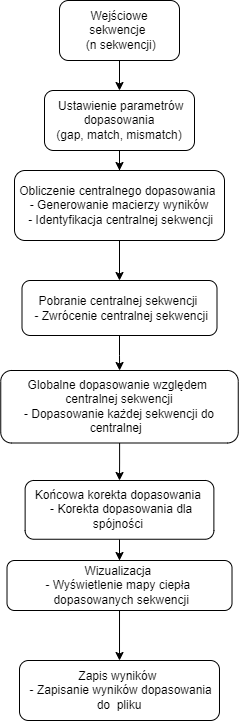



## Złożoność Czasowa

- Funkcja `central_alignment` dominuje złożoność czasową z złożonością $O(k^2 \cdot n \cdot m)$, , gdzie k to liczba sekwencji, a n i m to średnie długości sekwencji. Funkcja dopasowuje każdą sekwencję do każdej innej.
- Funkcja `final_MSA` również ma wpływ na złożoność czasową z złożonością $O(k \cdot n \cdot m)$, gdzie k to liczba sekwencji, a n i m to średnie długości sekwencji. Funkcja dopasowuje każdą sekwencję do centralnej.

### Łączna Złożoność Czasowa:
$O(k^2 \cdot n \cdot m) + O(k \cdot n \cdot m)$

## Złożoność Pamięciowa

- Funkcja `central_alignment` dominuje złożoność pamięciową z złożonością $O(k^2 + k \cdot n \cdot m)$, przechowuje macierze wyników dopasowania i macierze dynamicznego programowania dla każdej pary sekwencji.
- Funkcja `final_MSA` również wpływa na złożoność pamięciową z złożonością $O(k \cdot n \cdot m)$, na przechowanie macierzy dopasowania i wyników.

### Łączna Złożoność Pamięciowa:
$O(k^2 + k \cdot n \cdot m) + O(k \cdot n \cdot m)$
